In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as signal
from pathlib import Path
from filterpy.kalman import KalmanFilter, IMMEstimator
from filterpy.common import Q_discrete_white_noise, kinematic_kf
from scipy.linalg import block_diag

import os
import sys
sys.path.append("../src")

from fast_open_data import open_data_filter
from data_conversions import transition_matrix, sep_modo


In [2]:
S, R, L = open_data_filter(52, key = 'S1_Synched')
S1, R1, L1 = open_data_filter(23, key = 'S1_Synched')

# Aplicar o IMM para o movimento de levantar para os dados do tronco


In [3]:
freq_amostragem = 120
# dados para voluntário 52

sep = 465
# Sentar
est_sit_S = [ 140, 264, 365]
seq_sit_S = [1, 2, 3, 1]
S_sit = S[:sep]
classes_sit = np.unique(seq_sit_S)

# Levantar
est_rise_S = [570-sep, 647-sep, 725-sep]
seq_rise_S = [1, 2, 3, 1]
S_rise = S[sep:]
S1_rise = S1[sep:]
classes_rise = np.unique(seq_rise_S)


# dados para voluntário 52
estimated_R = [ 30, 330, 585, 740]
estimated_L = [ 100, 330, 595, 790]
estimated_S = [ 140, 264, 365, 570, 647, 725]

sequece_R_L = [1,2,3,4,1]
sequece_S = [1,2,3,1,2,3,1]

sequence = sequece_S.copy()
sequence.extend(sequece_R_L) 
classes = np.unique(sequence)

In [5]:
modo_rise_S, V_seq_rise_S, V_modo_rise_S, Var_seq_rise_S, Var_modo_rise_S = sep_modo(S_rise, est_rise_S, seq_rise_S, classes_rise)
modo_S, V_seq_S, V_modo_S, Var_seq_S, Var_modo_S = sep_modo(S, estimated_S, sequece_S, classes)
modo_L, V_seq_L, V_modo_L, Var_seq_L, Var_modo_L = sep_modo(L, estimated_L, sequece_R_L, classes)
modo_R, V_seq_R, V_modo_R, Var_seq_R, Var_modo_R = sep_modo(R, estimated_R, sequece_R_L, classes)

# Aplicar o filtro de Kalman individualmente para cada modelo

A intenção é obter o filtro mais restrito que funcione exclusivamente com o modelo fornecido, sem se adaptar as variações de velocidade do sensor. A ideia é de que esses filtros possam ser utilizados de forma a ter uma melhor assertividade no algoritmo IMM

# Descrição da aplicação do IMM (Filtro de Kalman com transição de estados da cadeia de Markov)

A ideia é ter um filtro para cada modo possível do comportamento do sistema. Em cada atualização, os filtros interagem entre si, de forma que os filtros mais prováveis modificam as estimativas dos filtros menos prováveis para que eles representa mais de perto o estado atual. É uma combinação feita probabilisticamente, então os filtros menos prováveis também modificam os filtros mais prováveis, porém em uma escala menor. 

# Probabilidades de modo

A partir da quantidade de modos existentes, ou seja, a partir da quantidade de filtros deve-se criar um vetor com as probabilidades de cada filtro, nesse caso existem 6 modos diferentes com sequência (1, 2, 3, 4, 5, 6, 1), dessa forma, existem 6 modos diferentes e devemos determinar a probabilidade inicial para cada um dos modos (filtros). 

$$\mu = \begin{bmatrix} 0.9 & 0.02 & 0.02 & 0.02 & 0.02 & 0.02\end{bmatrix}$$

Como $\mu$ é um vetor de probabilidades, a sua soma deve ser igual a 1. 

Formalizando, temos que a probabilidade anterior de $\mu_i$ estar correto (estado esteja no modo $i$), dadas as medições anteriores de $Z$, é: 

$$\mu_i = P(m_i|Z)$$


# Transições de modos

Em seguida, devemos determinar que cada um desses modos (filtros) é um estado de uma cadeia de Markov e devemos modelar as transições desse sistema como tal.  
Para representarmos a cadeia de Markov em uma matriz de probabilidades de transições, seguimos a definição de que a probabilidade de se mover de $i$ para $j$ em um intervalo de tempo é $Pr(j|i) = P(i,j)$ e assim a matriz estocástica pode ser definida, para S, da seguinte maneira: 

$$ \mathbf P=\begin{bmatrix}
P_{1,1}&P_{1,2}&\dots&P_{1,j}&\dots&P_{1,S}\\
P_{2,1}&P_{2,2}&\dots&P_{2,j}&\dots&P_{2,S}\\
\vdots&\vdots&\ddots&\vdots&\ddots&\vdots\\
P_{i,1}&P_{i,2}&\dots&P_{i,j}&\dots&P_{i,S}\\
\vdots&\vdots&\ddots&\vdots&\ddots&\vdots\\
P_{S,1}&P_{S,2}&\dots&P_{S,j}&\dots&P_{S,S}\\
\end{bmatrix} $$

Lembrando que a probabilidade de transição de um estado $i$ para todos os outros estados deve ser igual a 1. 

$$\sum_{j=1}^S P_{i,j}=1;\,$$

Dessa forma, temos que a probabilidade de mudança de um estado $i$ para um outro estado $j$ se dá pela quantidade de transições do estado $i$ para o estado $j$ dividido pela quantidade de amostras do estado $i$, dessa formas temos que a matriz de transição de estados pode ser gerada a partir do seguinte cálculo: 

$$ M_{i,j} =  \frac{\sum_{t=2}^T \mathcal{Y}_{i,j}}{\sum_{t=1}^T \mathcal{E}_{i}}$$ 

Onde $\mathcal{Y}_{i,j}$ é a função da quantidade de transições de $i$ para $j$ e $\mathcal{E}_{i}$ é a quantidade de transições de $i$ para $i$, ou seja, a quantidade de amostras sem que haja transição de estado. (Escrever essas funções de uma forma melhor, depois). 

Dessa forma, temos que a matriz de transições para esse caso é:

In [6]:
transitions_rise = transition_matrix(modo_rise_S, classes_rise)
transitions_rise = np.array([[0.987, 0.013, 0.],
                             [0., 0.987, 0.013],
                             [0.013, 0., 0.987]])

transitions_rise

array([[0.987, 0.013, 0.   ],
       [0.   , 0.987, 0.013],
       [0.013, 0.   , 0.987]])

$$\mathbf M = \begin{bmatrix}0.99659864&0.00340136&0&0&0&0\\0&0.99305556&0.00694444&0&0&0\\0&0&0.98958333&0.01041667&0&0\\0&0&0&0.9952381&0.0047619&0\\0&0&0&0&0.98701299&0.01298701\\0.00900901&0&0&0&0&0.99099099\end{bmatrix}$$

Podemos observar que estando no estado 1, as únicas transições possíveis é de se manter no estado 1 ou de mudar para o estado 2, dessa forma temos que a probabilidade de transição do estado 1 para os estados 2, 3, 4, 5 e 6 é igual a zero. Isso se repete de forma similar para todos os outros estados. 


Usando o teorema da probabilidade total, o qual afirma que a probabilidade de vários eventos distintos é: 

$$P(A) = \sum P(A\mid B)\, P(B)$$

Onde $P(A\mid B)$ é a matriz de transição $M$ e $P(B)$ é igual a $\mu$. Dessa forma, a multiplicação dessas duas matrizes, temos como resultado um somatório, usando como exemplo, as matrizes com apenas 2 estados, temos: 

$$\begin{bmatrix}\mu_1 & \mu_2 \end{bmatrix}\begin{bmatrix}m_{11} & m_{12}\\m_{21} & m_{22}\end{bmatrix} = \begin{bmatrix}\mu_1 m_{11} + \mu_2 m_{21} & \mu_1 m_{12} + \mu_2 m_{22}\end{bmatrix}$$

Generalizando, podemos representar da seguinte forma: 

$$\bar c_j = \sum\limits_{i=1}^{N} \mu_i M_{ij}$$

# Cálculo das probabilidades de cada modo

Para cada modo (filtro de Kalman), é calculado a probabilidade do modo como: a probabilidade do modo atual baseada nas possíveis transições vezes a probabilidade de estados do filtro de Kalman e por fim as probabilidades são normalizadas para sua soma ser igual a 1.

O filtro de Kalman calcula a probabilidade, que é a probabilidade do estados de acordo com o estado atual do filtro. Essa equação é: 

$$
\mathcal{L} = \frac{1}{\sqrt{2\pi \mathbf S}}\exp [-\frac{1}{2}\mathbf y^\mathsf T\mathbf S^{-1}\mathbf y]$$

** Explicar a matriz S **

Utilizando o teorema de Bayes, pode-se calcular as probabilidades dos novos estados. O teorema de Bayes afirma que:
$$\text{probabilidade do novo modo} = \frac{\text{probabilidade total anterior} \cdot \text{probabilidade do filtro de Kalman}}{\text{fator de normalização}}$$

Matematicamente, pode-se reescrever essa equação da sequinte forma: 

$$\mu_i = \| \mathcal{L}_i {\bar c}_{i}\|$$

Dessa forma a nova probabilidade de cada modo (filtro) é atualizada a cada interação do filtro de Kalman. 

# Misturando probabilidades

Teoricamente, poderíamos usar as transições de modos para calcular as probabilidades de todas as escolhas possíveis, porém, computacionalmente isso é inviável, pois a quantidade de possíveis probabilidades de estados aumentam exponencialmente, consumindo rapidamente vários gigas de memória RAM. 

Por isso utilizamos o algoritmo IMM, o qual resolve esse problema computando uma combinação das probabilidades. Isso é feito utilizando os filtros com maiores probabilidades para ajustar os filtros de menores proabilidades, fazendo uma média ponderada entre todos os filtros. 

Para realizar esses ajustes, temos que os valores de média e covariância de cada filtro de Kalman que são atualizados a cada etapa, porém esse cálculo será realizado novamente utilizando, para cada filtro, uma soma ponderada dessas médias e covariâncias de acordo com as probabilidades de misturas, que será chamada de $\omega$. Os filtros prováveis serão ligeiramente ajustados pelos filtros improváveis e os filtros improváveis serão fortemente ajustados pelos prováveis. Com isso, temos as seguintes equações de atualizações: 

$$\begin{aligned}
\mathbf x^m_j &= \sum_{i=1}^N \omega_{ij} \mathbf x_i \\
\mathbf P^m_j &= \sum_{i=1}^N \omega_{ij}\left[(\mathbf x^i - \mathbf  x^m_i) (\mathbf x^i - \mathbf  x^m_i)^\mathsf T + \mathbf P_i\right]
\end{aligned}$$

Onde $\mathbf x^m_j$ é o estado misto e $\mathbf P^m_j$ é a covariância mista. 

Apesar da notação, a ideia é simples, incorporar as estimativas dos filtros prováveis nas estimativas dos filtros improváveis, garantindo que todos tenham uma boa estimativa. 

Para calcular as probabiliades de misturas, devemos mais uma vez, recorrer ao teorema de Bayes, onde a probabilidade da mistura é dada pela probabilidade normalizada $\mu$ e a matriz de probabilidade de transição $M$. Dessa forma, temos a seguinte equação: 

$$\boldsymbol\omega_{ij} = \| \mu_i \cdot \mathbf M_{ij}\|$$



Dessa forma, o filtro de Kalman deve realizar a etapa de predição da nova estimativa (de posição nesse caso), utilizando as probabilidades de mistura, dessa formas temos que: 

$$
\begin{aligned}
\bar{\mathbf x}_j &= \mathbf F_j\mathbf x^m_j\\
\bar{\mathbf P}_j &= \mathbf F_j\mathbf P^m_j\mathbf F_j^\mathsf T + \mathbf Q_j
\end{aligned}$$

Agora, para finalizar, precisamos de uma estimativa de qual filtro é o que melhor representa o movimento atual (modo). Deve-se então, ponderar as estimativas mistas de cada filtro de Kalman, para isso, temos as seguintes equações: 

$$\begin{aligned}
\mathbf x &= \sum_{j=1}^N \mu_j{\bar{\mathbf x}}_j\\
\mathbf P &= \sum_{j=1}^N \mu_j\left[(\bar{{\mathbf x}}_j - \bar{\mathbf x})({\bar{\mathbf x}}_j - \bar{\mathbf x})^\mathsf T + \bar{\mathbf P_j}\right]
\end{aligned}$$


Aplicando esses conceitos, juntamente com os filtros de Kalman implementados no código Moviment_modes, temos: 

# Aplicando com o voluntário 52

In [7]:
kf1 = KalmanFilter(2, 1)
kf2 = KalmanFilter(2, 1)
kf3 = KalmanFilter(2, 1)

kf1.x = np.array([80, 1]).T
kf2.x = np.array([80, 1]).T
kf3.x = np.array([30, 1]).T

kf1.F = np.array([[1, 0.01],[0, 1]])
kf2.F = np.array([[1, -0.4],[0, 1]])
kf3.F = np.array([[1, 0.4],[0, 1]])

kf1.H = np.array([[1, 0]])
kf2.H = np.array([[1, 0]])
kf3.H = np.array([[1, 0]])

#r = 1000
kf1.R = 39.5
kf2.R = 38.5
kf3.R = 39.

kf1.Q = np.array([[0.02, 0],[0, 0.005]])
kf2.Q = np.array([[0.02, 0],[0, 0.005]])
kf3.Q = np.array([[0.02, 0],[0, 0.005]])




filters = [kf1, kf2, kf3]
mu = [0.98, 0.01, 0.01]  # each filter is equally likely at the start
M = np.array(transitions_rise)
imm_rise_S = IMMEstimator(filters, mu, M)

In [8]:
results = []
prob_estado = []
transitions = []
z = np.c_[S]
imm = []
modelo = []

for i, z in enumerate(z):
   

    # perform predict/update cycle
    imm_rise_S.predict()
    imm_rise_S.update(z)

    results.append(imm_rise_S.x.copy())
    prob_estado.append(imm_rise_S.mu.copy())
    transitions.append(imm_rise_S.omega.copy())
    #imm_rise_S.x = np.array([imm_rise_S.x[0], [1]])
    imm.append(imm_rise_S)
    estado = np.where(imm_rise_S.mu == max(imm_rise_S.mu))[0][0]
    modelo.append(estado)
    
results = np.array(results)
prob_estado = np.array(prob_estado)
transitions = np.array(transitions)
modelo = np.array(modelo)
modelo += 1



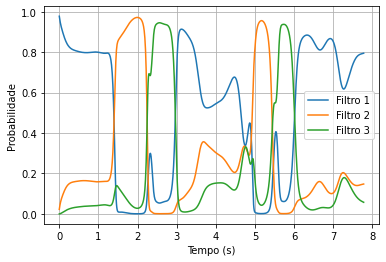

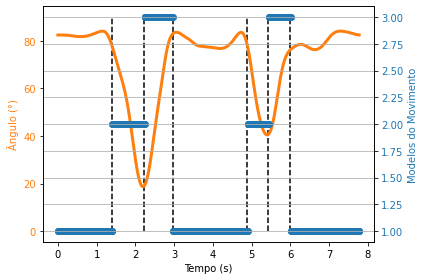

[167, 268, 355, 587, 652, 720]

In [9]:
f_name = '../images/'
freq_amostragem = 120
# Criando vetor de tempo
t = np.linspace(0, len(S) / freq_amostragem, len(modelo))

plt.plot(t, prob_estado[:,0], label = 'Filtro 1')
plt.plot(t, prob_estado[:,1], label = 'Filtro 2')
plt.plot(t, prob_estado[:,2], label = 'Filtro 3')
plt.legend()
#plt.title('Provavilidade de cada estado (filtro)')
plt.ylabel('Probabilidade')
plt.xlabel('Tempo (s)')
plt.grid()
plt.savefig(f_name + 'Probabilidades_Rise_Tronco.png')
plt.show()

fig, ax1 = plt.subplots()

est_S = []
for i in range(len(modelo)-1):
    if (modelo[i] != modelo[i+1]):
        est_S.append(i)
        plt.vlines(x=(i/(np.array(freq_amostragem))), ymin=0, ymax=90, linestyles ="dashed", colors ="k")

color = 'tab:orange'
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Ângulo (°)', color=color)
ax1.plot(t, S, color=color, linewidth=3)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Modelos do Movimento', color=color) 
ax2.scatter(t, modelo, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
#plt.legend()
plt.grid()
plt.savefig(f_name + 'Estados_Rise_Tronco_generico.png')
plt.show()

est_S

# Aplicar o IMM para o movimento de levantar para os dados da perna esquerda

In [10]:
est_L = [ 100, 320, 605, 790]
seq_L = [1,2,3,4,1]

sequence = seq_L.copy()
classes_L = np.unique(sequence)
modo_L, V_seq_L, V_modo_L, Var_seq_L, Var_modo_L = sep_modo(L, est_L, seq_L, classes_L)

In [11]:
transitions_L = transition_matrix(modo_L, classes_L)
transitions_L = np.array([[0.98586777, 0.01413223, 0.        , 0.        ],
                          [0.        , 0.98545455, 0.01454545, 0.        ],
                          [0.        , 0.        , 0.98649123, 0.01350877],
                          [0.01540541, 0.        , 0.        , 0.98459459]])

transitions_L

array([[0.98586777, 0.01413223, 0.        , 0.        ],
       [0.        , 0.98545455, 0.01454545, 0.        ],
       [0.        , 0.        , 0.98649123, 0.01350877],
       [0.01540541, 0.        , 0.        , 0.98459459]])

In [12]:
kf1 = KalmanFilter(2, 1)
kf2 = KalmanFilter(2, 1)
kf3 = KalmanFilter(2, 1)
kf4 = KalmanFilter(2, 1)

kf1.x = np.array([95, 1]).T
kf2.x = np.array([95, 1]).T
kf3.x = np.array([20, 1]).T
kf4.x = np.array([20, 1]).T

kf1.F = np.array([[1, 0.005],[0, 1]])
kf2.F = np.array([[1, -0.4],[0, 1]])
kf3.F = np.array([[1, 0.005],[0, 1]])
kf4.F = np.array([[1, 0.4],[0, 1]])

kf1.H = np.array([[1, 0]])
kf2.H = np.array([[1, 0]])
kf3.H = np.array([[1, 0]])
kf4.H = np.array([[1, 0]])

r = 10000
kf1.R = 5.040
kf2.R = 5.100
kf3.R = 4.980
kf4.R = 4.990

kf1.Q = np.array([[0.02, 0],[0, 0.005]])
kf2.Q = np.array([[0.02, 0],[0, 0.005]])
kf3.Q = np.array([[0.02, 0],[0, 0.005]])
kf4.Q = np.array([[0.02, 0],[0, 0.005]])

#kf1.Q = np.array([[Var_modo_rise_S[0], 0],[0, Var_modo_rise_S[0]]])
#kf2.Q = np.array([[Var_modo_rise_S[1], 0],[0, Var_modo_rise_S[1]]])
#kf3.Q = np.array([[Var_modo_rise_S[2], 0],[0, Var_modo_rise_S[2]]])

filters = [kf1, kf2, kf3, kf4]
mu = [0.97, 0.01, 0.01, 0.01]  # each filter is equally likely at the start
M = np.array(transitions_L)
imm_L = IMMEstimator(filters, mu, M)

In [13]:
results = []
prob_estado = []
transitions = []
z = np.c_[L]
imm = []
modelo = []

for i, z in enumerate(z):
   
    
    # perform predict/update cycle
    imm_L.predict()
    imm_L.update(z)
    
    results.append(imm_L.x.copy())
    prob_estado.append(imm_L.mu.copy())
    transitions.append(imm_L.omega.copy())
    #imm_rise_S.x = np.array([imm_rise_S.x[0], [1]])
    imm.append(imm_L)
    estado = np.where(imm_L.mu == max(imm_L.mu))[0][0]
    modelo.append(estado)
    
results = np.array(results)
prob_estado = np.array(prob_estado)
transitions = np.array(transitions)
modelo = np.array(modelo)
modelo += 1

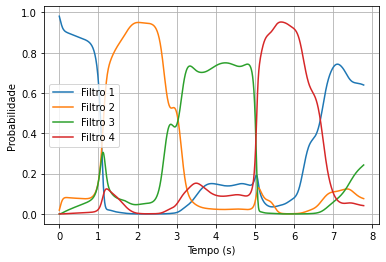

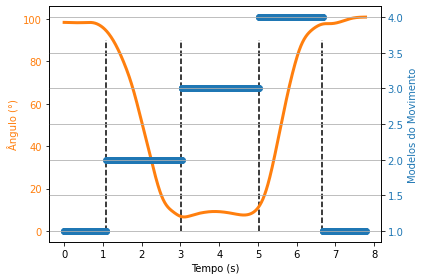

[129, 363, 602, 799]

In [14]:
t = np.linspace(0, len(L) / freq_amostragem, len(modelo))

plt.plot(t, prob_estado[:,0], label = 'Filtro 1')
plt.plot(t, prob_estado[:,1], label = 'Filtro 2')
plt.plot(t, prob_estado[:,2], label = 'Filtro 3')
plt.plot(t, prob_estado[:,3], label = 'Filtro 4')
plt.legend()
#plt.title('Provavilidade de cada estado (filtro)')
plt.ylabel('Probabilidade')
plt.xlabel('Tempo (s)')
plt.grid()
plt.savefig(f_name + 'Probabilidades_perna.png')
plt.show()

fig, ax1 = plt.subplots()

est_L = []
for i in range(len(modelo)-1):
    if (modelo[i] != modelo[i+1]):
        est_L.append(i)
        plt.vlines(x=(i/(np.array(freq_amostragem))), ymin=0, ymax=90, linestyles ="dashed", colors ="k")

color = 'tab:orange'
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Ângulo (°)', color=color)
ax1.plot(t, L, color=color, linewidth=3)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Modelos do Movimento', color=color) 
ax2.scatter(t, modelo, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
#plt.legend()
plt.grid()
plt.savefig(f_name + 'Estados_perna_generico.png')
plt.show()

est_L

# Cálculo de atraso para as transições

In [15]:
print(est_L)
print(estimated_L)
est_L = np.array(est_L)
estimated_L = np.array(estimated_L)
print(np.mean(est_L - estimated_L))
print('erro máximo =', t[int(np.max(est_L - estimated_L))])
print('erro médio =',t[int(np.mean(abs(est_L - estimated_L)))])

[129, 363, 602, 799]
[100, 330, 595, 790]
19.5
erro máximo = 0.2752950643776824
erro médio = 0.15850321888412017


In [16]:
print(est_S)
print(estimated_S)
est_S = np.array(est_S)
estimated_S = np.array(estimated_S)
print(np.mean(est_S - estimated_S))
print('erro máximo =', t[int(np.max(est_S - estimated_S))])
print('erro médio =',t[int(np.mean(abs(est_S - estimated_S)))])

[167, 268, 355, 587, 652, 720]
[140, 264, 365, 570, 647, 725]
6.333333333333333
erro máximo = 0.22524141630901287
erro médio = 0.09176502145922746


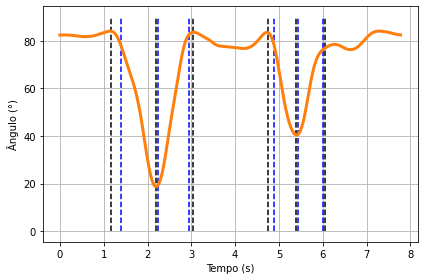

In [17]:
fig, ax1 = plt.subplots()

f_name = '../images/'

for i in range(len(estimated_S)):
    plt.vlines(x=(estimated_S[i]/(np.array(freq_amostragem))), ymin=0, ymax=90, linestyles ="dashed", colors ="k")

for i in range(len(est_S)):
    plt.vlines(x=(est_S[i]/(np.array(freq_amostragem))), ymin=0, ymax=90, linestyles ="dashed", colors ="b")

color = 'tab:orange'
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Ângulo (°)')
ax1.plot(t, S, color=color, linewidth=3)
#ax1.tick_params(axis='y', labelcolor=color)


fig.tight_layout() 
#plt.legend()
plt.grid()
plt.savefig(f_name + 'IMM_generic_atraso_tronco.png')
plt.show()

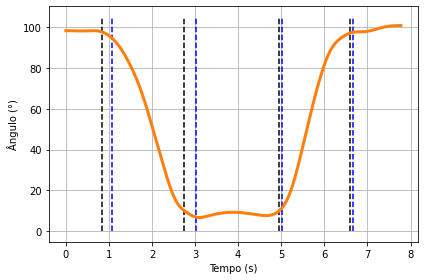

In [18]:
fig, ax1 = plt.subplots()

f_name = '../images/'

for i in range(len(estimated_L)):
    plt.vlines(x=(estimated_L[i]/(np.array(freq_amostragem))), ymin=0, ymax=105, linestyles ="dashed", colors ="k")

for i in range(len(est_L)):
    plt.vlines(x=(est_L[i]/(np.array(freq_amostragem))), ymin=0, ymax=105, linestyles ="dashed", colors ="b")

color = 'tab:orange'
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Ângulo (°)')
ax1.plot(t, L, color=color, linewidth=3)
#ax1.tick_params(axis='y', labelcolor=color)


fig.tight_layout() 
#plt.legend()
plt.grid()
plt.savefig(f_name + 'IMM_generic_atraso_perna.png')
plt.show()

In [19]:
sequence_SL =  [ 1, 2, 3, 4]
class_SL = np.unique(sequence_SL)

estimated_L = [ 100, 330, 595, 790]
estimated_S = [ 140, 264, 365, 570, 647, 725]

In [20]:
sep = int((est_S[2] + est_S[3])/2)

estimated_sit_SL = np.array([max(est_S[0], est_L[0]), est_S[1], est_S[2]])
estimated_sit_SL = np.sort(estimated_sit_SL)
S_sit = S[:sep]
L_sit = L[:sep]
#R_sit = R1[:sep_ref]

sep_ref = int((estimated_S[2] + estimated_S[3])/2)

estimated_sit_ref_SL = np.array([max(estimated_S[0], estimated_L[0]), estimated_S[1], estimated_S[2]])
estimated_sit_ref_SL = np.sort(estimated_sit_ref_SL)
S_sit_ref = S[:sep]
L_sit_ref = L[:sep]
#R_sit_ref = R[:sep_ref]

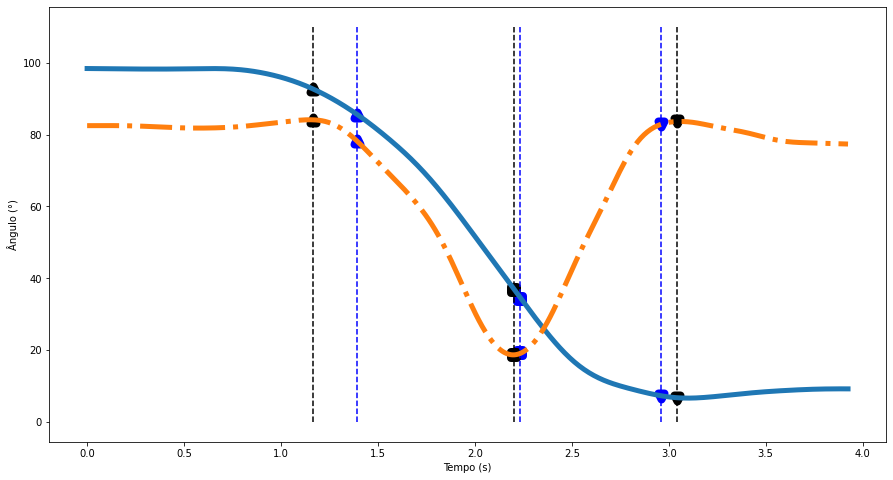

In [73]:
t_sit = np.linspace(0, len(S_sit) / 120, len(S_sit))

markers=['^', 's', 'v', 'D', 'p', 'h', '8', 'P', '*', 'x']

rowing_phases_leg = ['Dobrar Perna Sentar', 'Perna Dobrada', 'Esticar Perna Levantar', 'Perna Esticada']
rowing_phases_spine = ['Inclinar Tronco Sentar', 'Inclinação Máxima do Tronco', 'Sentado Estabilizado', 
                        'Inclinar Tronco Levantar', 'Inclinação Máxima Levantar', 'Em Pé Estabilizado ']
cores = ['k', 'y', 'r', 'c', 'm', 'w', 'b', 'g', 'peru', 'cyan']

fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=[15,8])
ax1.plot(t_sit, L_sit, label='Perna Esquerda', 
         linewidth=5)
ax1.plot(t_sit, S_sit, label='Tronco', 
         linestyle='-.', linewidth=5)


for i in range(len(estimated_sit_SL)):    
    ax1.scatter(estimated_sit_SL[i]/(np.array(freq_amostragem)), L_sit[estimated_sit_SL[i]], 
            marker=markers[i], color='blue', linewidth=8)
    ax1.scatter(estimated_sit_SL[i]/(np.array(freq_amostragem)), S_sit[estimated_sit_SL[i]], 
            marker=markers[i], color='blue', linewidth=8)
    
    plt.vlines(x=(estimated_sit_SL[i]/(np.array(freq_amostragem))), ymin=0, ymax=110, linestyles ="dashed", colors ="b")
    #plt.hlines(y=(S[estimated_sit_SL[1]]), xmin=0, xmax=t_sit[len(t_sit)-1], linestyles ="dashed", colors ="b")
    
for i in range(len(estimated_sit_ref_SL)):    
    ax1.scatter(estimated_sit_ref_SL[i]/(np.array(freq_amostragem)), L_sit_ref[estimated_sit_ref_SL[i]], 
            marker=markers[i], color='black', linewidth=8)
    ax1.scatter(estimated_sit_ref_SL[i]/(np.array(freq_amostragem)), S_sit_ref[estimated_sit_ref_SL[i]], 
            marker=markers[i], color='black', linewidth=8)
    
    plt.vlines(x=(estimated_sit_ref_SL[i]/(np.array(freq_amostragem))), ymin=0, ymax=110, linestyles ="dashed", colors ="k")
    #plt.hlines(y=(S[estimated_sit_ref_SL[1]]), xmin=0, xmax=t_sit[len(t_sit)-1], linestyles ="dashed", colors ="k")
    

f_name = '../images/'
#plt.title('Fases do DTW para sentar e levantar')
#plt.legend()
plt.ylabel('Ângulo (°)')
plt.xlabel('Tempo (s)')
plt.grid(False)
plt.axis(True)
#plt.grid()
#fig.tight_layout()
plt.savefig(f_name + 'Erro_angulo_IMM1.png')
plt.show()

In [23]:
estimated_rise_SL = np.array([est_S[3]-sep, est_S[4]-sep, min(est_S[5], est_L[3])-sep])
estimated_rise_SL = np.sort(estimated_rise_SL)

S_rise = S[sep:]
L_rise = L[sep:]
#R_rise_alvo = R[sep:]


estimated_rise_ref_SL = np.array([estimated_S[3]-sep, estimated_S[4]-sep, 
                     min(estimated_S[5], estimated_L[3])-sep])
estimated_rise_ref_SL = np.short(estimated_rise_ref_SL)

S_rise_ref = S[sep:]
L_rise_ref = L[sep:]
#R_rise_ref = R_ref[sep_ref:]

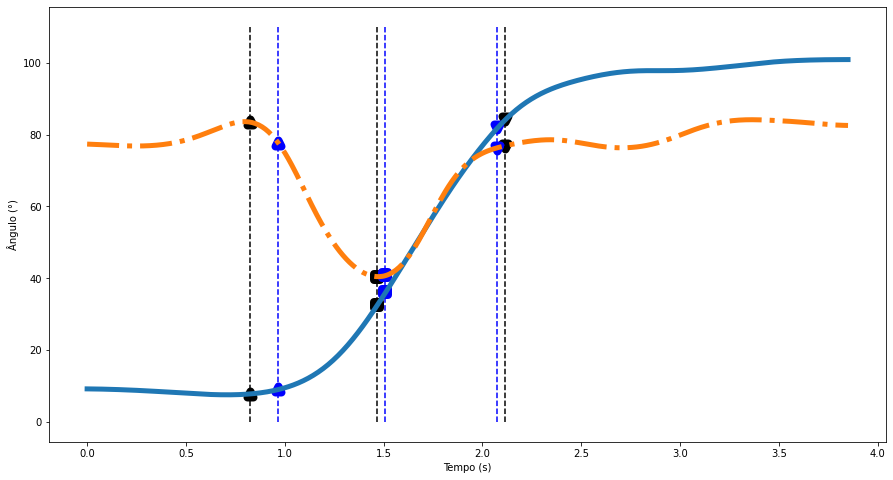

In [70]:
t_rise = np.linspace(0, len(S_rise) / 120, len(S_rise))

fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=[15,8])
ax1.plot(t_rise, L_rise, label='Perna esquerda filtrada em 0,7 Hz', 
         linewidth=5)
ax1.plot(t_rise, S_rise, label='Tronco filtrado em 1,3 Hz', 
         linestyle='-.', linewidth=5)

for i in range(len(estimated_rise_ref_SL)):    
    ax1.scatter(estimated_rise_ref_SL[i]/(np.array(freq_amostragem)), L_rise_ref[estimated_rise_ref_SL[i]], 
            marker=markers[i], color='black', linewidth=8)
    ax1.scatter(estimated_rise_ref_SL[i]/(np.array(freq_amostragem)), S_rise_ref[estimated_rise_ref_SL[i]], 
            marker=markers[i], color='black', linewidth=8)
    
    plt.vlines(x=(estimated_rise_ref_SL[i]/(np.array(freq_amostragem))), ymin=0, ymax=110, linestyles ="dashed", colors ="k")
    
for i in range(len(estimated_rise_SL)):    
    ax1.scatter(estimated_rise_SL[i]/(np.array(freq_amostragem)), L_rise[estimated_rise_SL[i]], 
            marker=markers[i], color='blue', linewidth=8)
    ax1.scatter(estimated_rise_SL[i]/(np.array(freq_amostragem)), S_rise[estimated_rise_SL[i]], 
            marker=markers[i], color='blue', linewidth=8)
    
    plt.vlines(x=(estimated_rise_SL[i]/(np.array(freq_amostragem))), ymin=0, ymax=110, linestyles ="dashed", colors ="b")

#plt.title('Fases do DTW para sentar e levantar')
#plt.legend()
plt.ylabel('Ângulo (°)')
plt.xlabel('Tempo (s)')
plt.grid(False)
plt.axis(True)
#plt.grid()
#fig.tight_layout()
plt.savefig(f_name + 'Erro_angulo_IMM2.png')
plt.show()